# OptiMask: Efficient Python Package for NaN Data Removal

Introducing OptiMask, a Python package designed to simplify the process of removing NaN (Not-a-Number) data from matrices while efficiently computing the largest (and non necessarily contiguous) submatrix without NaN. OptiMask focuses on providing immediate results, seamless compatibility with both Numpy arrays and Pandas DataFrames, and a user-friendly experience.

Highlights:

- NaN Data Removal: OptiMask streamlines the removal of NaN data from matrices, ensuring data integrity.
- Largest Submatrix: OptiMask computes the largest submatrix without NaN, enhancing data analysis accuracy.
- Swift Computation: With its fast computation, OptiMask swiftly generates results without unnecessary delays.
- Numpy and Pandas: Whether you use Numpy or Pandas, OptiMask adapts to your preferred data structure.
- Simplicity: OptiMask boasts a straightforward Python interface, making it easy for users of all levels to navigate.


Cyril Joly

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from optimask import OptiMask
from shapely import box

In [2]:
def plot(data, figsize=None, title=None, show=True):
    cmap = plt.get_cmap("Spectral_r")
    cmap.set_bad('grey')
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.pcolormesh(data, cmap=cmap)
    plt.gca().axis('off')
    plt.gca().set_aspect('equal')
    plt.title(title)
    if show:
        plt.show()


def generate_random(m, n, ratio):
    arr = np.zeros((m, n))
    nan_count = int(ratio * m * n)
    indices = np.random.choice(m * n, nan_count, replace=False)
    arr.flat[indices] = np.nan
    return arr

# 1. Understanding the problem at hand

In the context of a matrix containing a lone NaN cell, the central challenge emerges: determining whether to eliminate the corresponding row or column. This decision is readily resolved by examining the matrix's shape. Specifically, if the matrix has a greater number of rows than columns, the optimal approach involves removing the associated row. Conversely, when the matrix has more columns than rows, the most effective course of action is to eliminate the corresponding column:

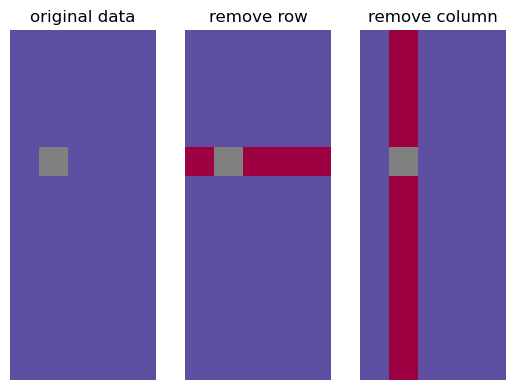

In [3]:
x = np.zeros((12, 5))
x[7, 1] = np.nan

x1 = x.copy()
x1[7] += 1

x2 = x.copy()
x2[:, 1] += 1

plt.figure()
plt.subplot(1, 3, 1)
plot(x, show=False, title='original data')
plt.subplot(1, 3, 2)
plot(x1, show=False, title='remove row')
plt.subplot(1, 3, 3)
plot(x2, show=False, title='remove column')
plt.show()

Eliminating the highlighted row yields the most extensive submatrix devoid of NaN. This solution remains optimal even when additional NaN values are present within the same row:

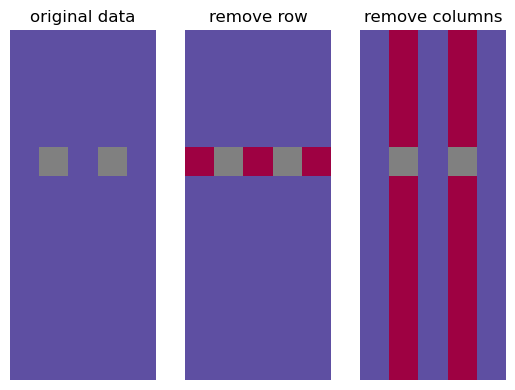

In [4]:
x = np.zeros((12, 5))
x[7, [1, 3]] = np.nan

x1 = x.copy()
x1[7] += 1

x2 = x.copy()
x2[:, [1, 3]] += 1

plt.figure()
plt.subplot(1, 3, 1)
plot(x, show=False, title='original data')
plt.subplot(1, 3, 2)
plot(x1, show=False, title='remove row')
plt.subplot(1, 3, 3)
plot(x2, show=False, title='remove columns')
plt.show()

But what about more complex cases ? 

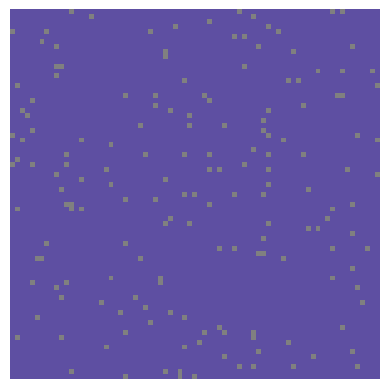

In [10]:
m, n = 75, 75
ratio = 0.03
x = generate_random(m, n, ratio)

plot(x)

## 2. The Problem from an Optimization Perspective

This problem can be formalized as a binary optimization problem in two ways.

### 2.1. Linear programming

Source : [this mathematica.stackexchange answer](https://mathematica.stackexchange.com/a/108513/92680), posted by [unlikely](https://mathematica.stackexchange.com/users/16267/unlikely).

Given:

- Matrix $A$ of shape $m \times n$ and elements $a_{i,j}$
- The goal is to determine the values of variables $(i \in [1~..~m]$, $j \in [1~..~n])$:
  - $e_{i,j} \in \{0,1\}$ (1 if element $(i,j)$ should be removed, 0 otherwise)
  - $r_i \in \{0,1\}$ (1 if row $i$ should be removed, 0 otherwise)
  - $c_j \in \{0,1\}$ (1 if column $j$ should be removed, 0 otherwise)



Subject to:


- $e_{i,j} = 1$ for every $(i,j)$ such that $a_{i,j}$ is a NaN
- $r_i + c_j \geq e_{i,j}$, meaning if $e_{i,j} = 1$ then either $r_i = 1$ or $c_j = 1$, or both
- $e_{i,j} \geq r_i$, indicating if $r_i = 1$ then $e_{i,j}$ must be 1
- $e_{i,j} \geq c_j$, indicating if $c_j = 1$ then $e_{i,j}$ must be 1

The objective is to minimize the total number of remaining cells:

$$\sum_{i=1}^{m} \sum_{j=1}^{n} e_{i,j}$$

The optimal values of $r_i$ and $c_j$ provide us with the specific rows and columns to remove, ensuring that the remaining matrix is efficiently processed and devoid of NaN values. This problem can be solved in Python using the usual tools of linear programming, such as combining Pyomo with GLPK. Its disadvantage is being relatively expensive, as for an $m \times n$ matrix, more than $m \times n$ (binary) variables are used.

### 2.2. Quadratic Programming

By employing the variables mentioned earlier, an alternate perspective of the problem involves maximizing $$(m-\sum_{i=1}^m r_i) \times (n-\sum_{i=1}^n c_j)$$
while considering:
- $r_i + c_j \ge 1$ for each $(i,j)$ where $a_{i,j}$ is a NaN.

Although the number of variables is reduced, the optimization problem becomes more challenging.

# 3. OptiMask's algorithm

We propose an algorithm for computing the optimal set of rows and columns to remove in order to retrieve the largest submatrix without containing any NaN values. Its convergence has not been proven yet.

The idea is to successively compute row and column permutations until a specific criterion is met. The criterion involves the emergence of a contiguous, well-ordered NaN frontier, which bears similarities to a Pareto efficiency frontier. Subsequently, the problem simplifies to the computation of the largest contiguous rectangle, which can be computed directly. The stored row and column permutations finally enable the identification of the rows and columns to be removed.

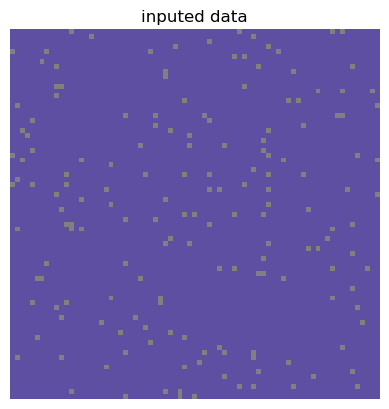

In [16]:
plot(x, title='inputed data')

A look at the computation of column and row permutations resulting in a so-called 'Pareto-ordered' mask (valid data is in purple, and the locations of NaN values are in red). A mask is considered Pareto-ordered if:

- When traversing the columns from left to right, the indices of the upper red cells are decreasing.
- When traversing the rows from bottom to top, the indices of the leftmost red cells are decreasing.

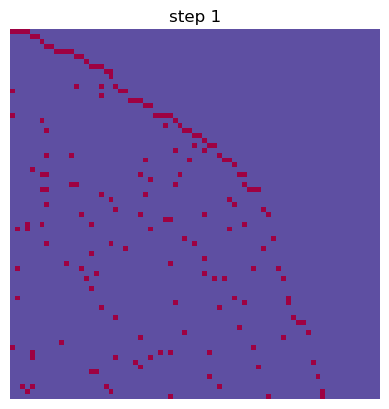

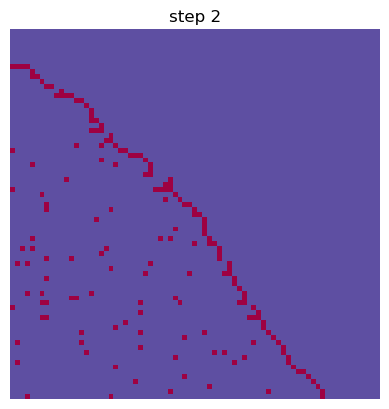

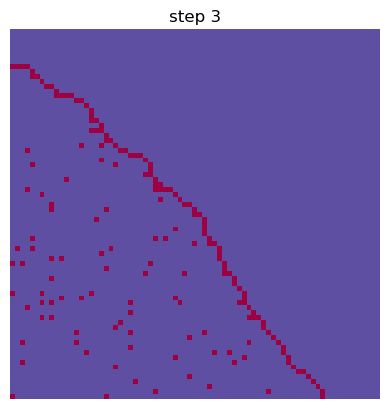

In [12]:
xp = np.isnan(x)

step = 0
while not OptiMask._is_pareto_ordered(xp):
    axis = (step % 2)
    xp, _ = OptiMask._process_step(xp, axis=axis)
    plot(xp, title=f'step {step+1}')
    step += 1

The compuatation of the largest rectangle without red cells is now direct

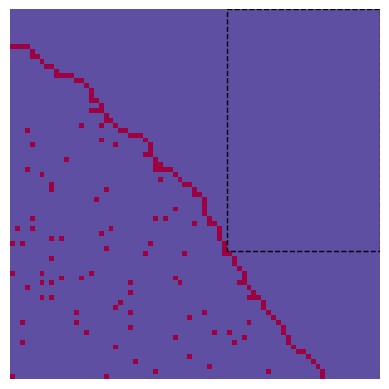

In [13]:
i0, j0 = OptiMask._get_largest_rectangle(xp)

r = gpd.GeoSeries([box(i0, j0, n, m)])

plot(xp, show=False)
r.plot(ax=plt.gca(), fc='none', linestyle='dashed')
plt.show()

# Optimask `solve`

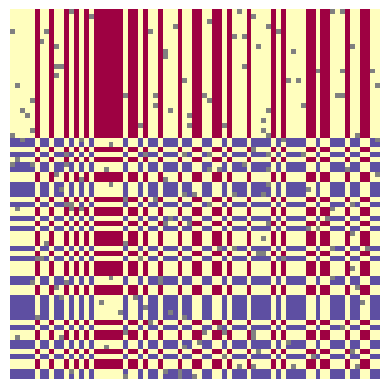

In [14]:
rows, cols = OptiMask.solve(x)

x_sub = x.copy()
x_sub[rows] += 1
x_sub[:, cols] += 1
plot(x_sub)